First, copy `log.lammps` and `dump.lammpstrj` to the same experiment path as `.pos` and `.in` files were generated (in my case it's `data/03_run_experiments_13-06-24`)

Using the file `log.lammps` we plot curves derived from the experiment. Using the file `dump.lammpstrj` we do clustering on different steps of simulation using Ovito API for Python (in a Destop app it is very routine and time-consuming process) and plot the heatmaps for bacteria types.

In [495]:
from os.path import join
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial import distance

In [496]:
experiment_id = "03_run_experiments_25-06-24_vilbac_0.04_75K"
experiment_type = "both_reshuffled"

### Plot heatmap based on an interaction matrix by Antton

In [497]:
num_bac_genomes = pd.read_csv(f"../../data/01_bacteria_amount/bac_amount_14010_mult_11.75044630883565_thresh_10.tsv", sep='\t')
SHIFT = 3 # 1 -- only bac; 3 -- villi + bac
num_bac_genomes.index = num_bac_genomes.index + SHIFT

rename_dict = dict(zip(num_bac_genomes['genome'], num_bac_genomes.index))

genome_distance_matrix = pd.read_csv("../../data/input_files/genome_functional.distances.txt", sep=" ")
genome_distance_matrix_selected = genome_distance_matrix.loc[list(num_bac_genomes['genome']), list(num_bac_genomes['genome'])]

genome_distance_matrix_renamed = genome_distance_matrix_selected.copy()
genome_distance_matrix_renamed.index = list(map(lambda x: rename_dict[x], genome_distance_matrix_renamed.index))
genome_distance_matrix_renamed.columns = list(map(lambda x: rename_dict[x], genome_distance_matrix_renamed.columns))

/var/folders/ns/t4fb57j54qlg7rb7g3jdcx5c0000gn/T/ipykernel_73807/336114810.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(genome_distance_matrix_selected, method='average')
/Users/nbykov/miniconda3/envs/gorgona/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/nbykov/miniconda3/envs/gorgona/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


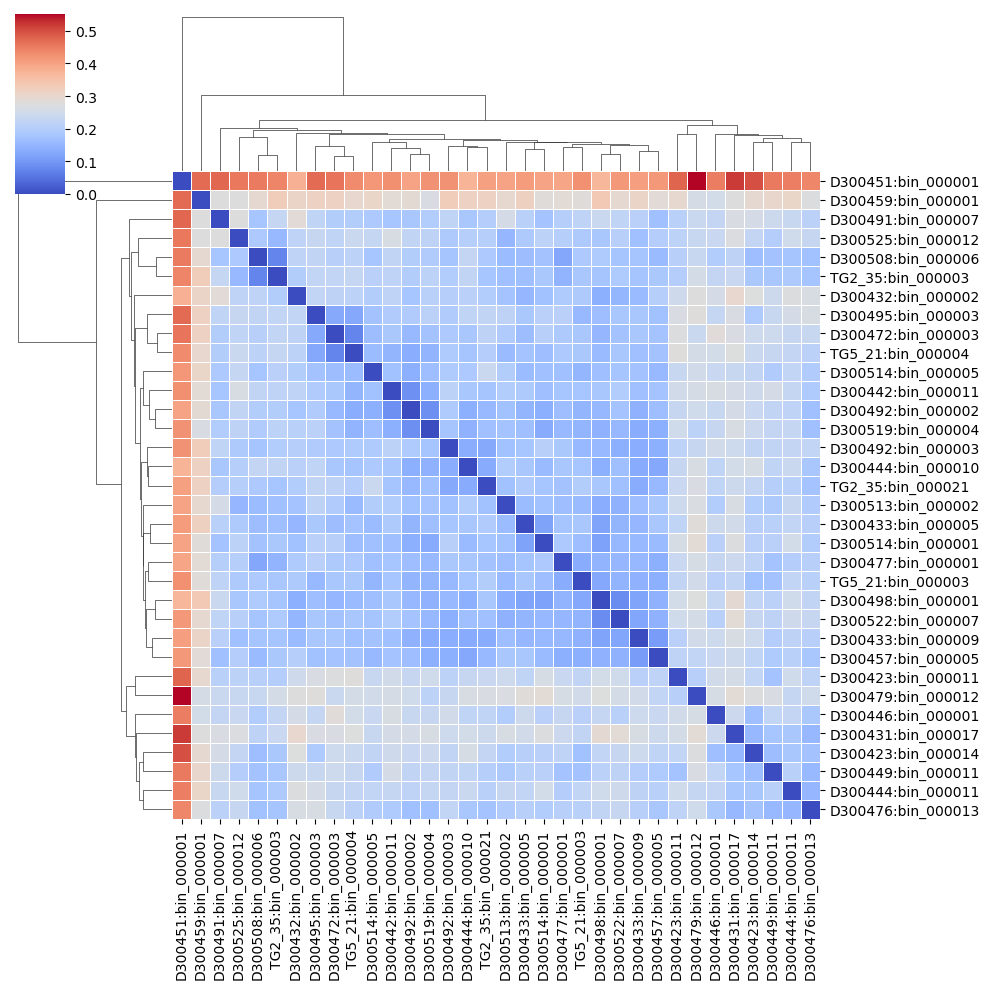

In [498]:
# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(genome_distance_matrix_selected, method='average')

# Define the order of columns based on clustering
order = hierarchy.leaves_list(linkage_matrix)

# Reorder the DataFrame columns based on the clustering order
df_reordered = genome_distance_matrix_selected.iloc[order, order]

# Create a heatmap with a tree hierarchy
sns.clustermap(df_reordered, row_cluster=True, col_cluster=True, cmap='coolwarm', linewidths=0.5, figsize=(10, 10))
#plt.tight_layout()
plt.savefig(f"../../data/{experiment_id}/{experiment_type}/01_orig_coefs_orig_types.png", dpi=300)
plt.show()


/var/folders/ns/t4fb57j54qlg7rb7g3jdcx5c0000gn/T/ipykernel_73807/3960023726.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(genome_distance_matrix_renamed, method='average')
/Users/nbykov/miniconda3/envs/gorgona/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/nbykov/miniconda3/envs/gorgona/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


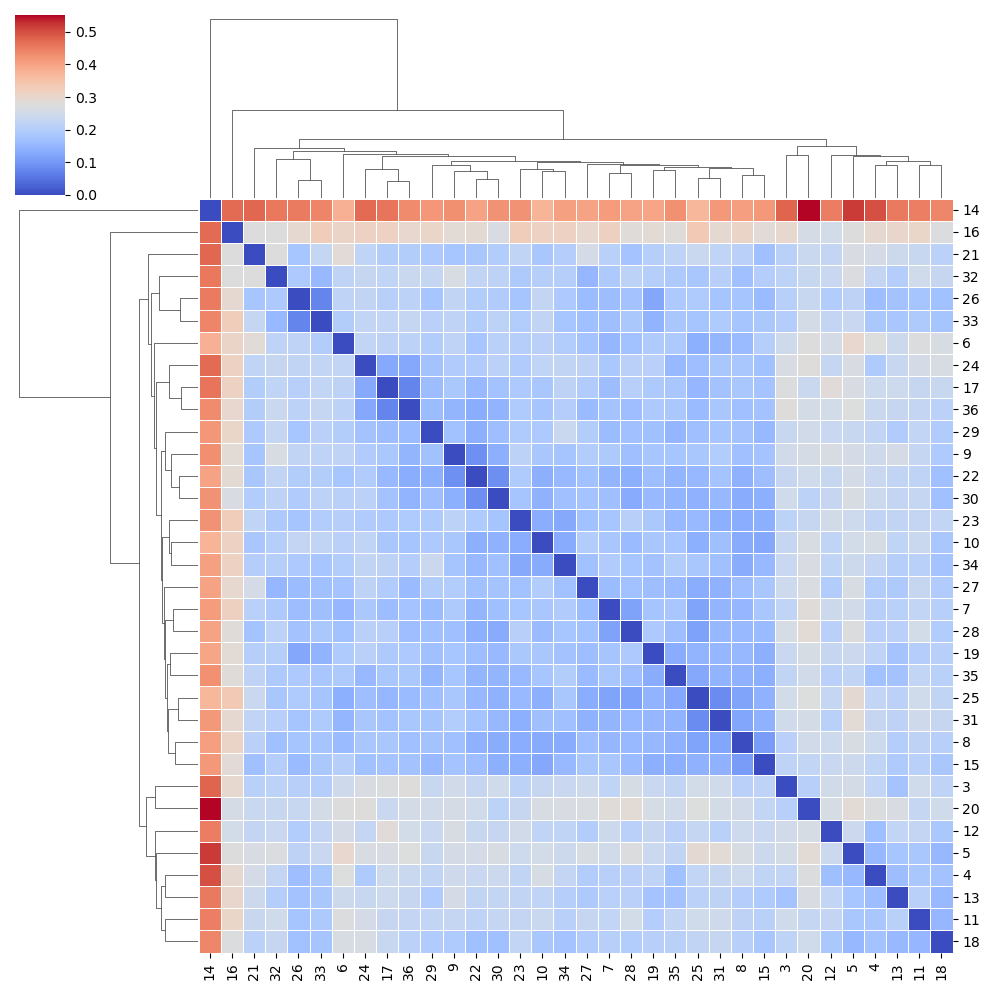

In [499]:
# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(genome_distance_matrix_renamed, method='average')

# Define the order of columns based on clustering
order = hierarchy.leaves_list(linkage_matrix)

# Reorder the DataFrame columns based on the clustering order
df_reordered = genome_distance_matrix_renamed.iloc[order, order]

# Create a heatmap with a tree hierarchy
sns.clustermap(df_reordered, row_cluster=True, col_cluster=True, cmap='coolwarm', linewidths=0.5, figsize=(10, 10))
#plt.tight_layout()
plt.savefig(f"../../data/{experiment_id}/{experiment_type}/01_orig_coefs_lammps_types.png", dpi=300)
plt.show()


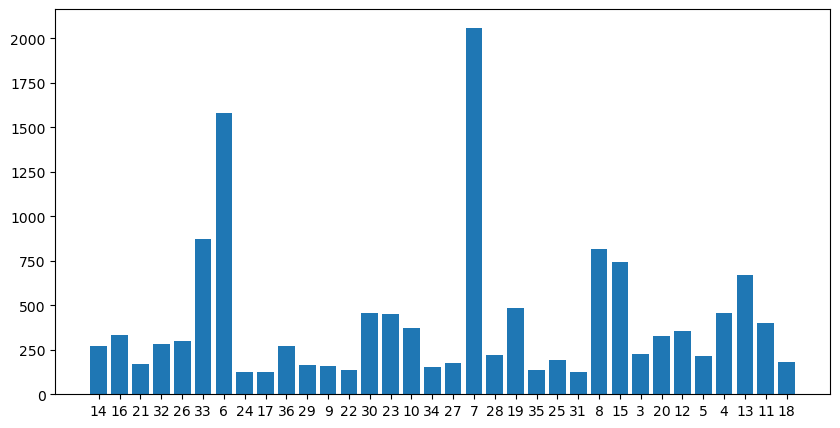

In [500]:
fig, ax = plt.subplots(figsize=(10,5))
plt.bar([str(x) for x in list(num_bac_genomes.loc[df_reordered.index].index)], list(num_bac_genomes.loc[df_reordered.index]['count']))
#plt.ylabel("Number of genomes", size=15)
#plt.xlabel("Bacterial type", size=15)
plt.savefig(f"../../data/{experiment_id}/{experiment_type}/01_bac_freqs_orig_coefs.png", dpi=300)
plt.show()

In [501]:
# check if mean input coefficients for each type correlate with the number of genomes for each type

from scipy.stats import pearsonr, spearmanr, kendalltau

df_reordered_corr = df_reordered.copy()

print("Correlation for all types:")
correlation, pvalue = pearsonr(df_reordered_corr.mean(), num_bac_genomes.loc[df_reordered_corr.index]['count'])
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(df_reordered_corr.mean(), num_bac_genomes.loc[df_reordered_corr.index]['count'])
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(df_reordered_corr.mean(), num_bac_genomes.loc[df_reordered_corr.index]['count'])
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))

# They do not correlate. This means that there is not bias in the input data towards the number of genomes for each type

Correlation for all types:
Pearson correlation: -0.10282, 5.62811E-01
Spearman correlation: -0.01085, 9.51440E-01
Kendall correlation: -0.01964, 8.70436E-01


# Cluster analysis

In [502]:
from glob import glob
from itertools import product
from tqdm import tqdm
import numpy as np
from scipy.spatial import distance

from ovito.io import import_file
from ovito.modifiers import ClusterAnalysisModifier

In [503]:
# do clustering for experiment

input_trajectory_file = f"../../data/{experiment_id}/{experiment_type}/dump.lammpstrj"
cluster_cutoff = 0.06 # 0.18 0.06
start_frame = 2500
end_frame = 3000
delta = 50

In [504]:
pipeline = import_file(input_trajectory_file)
modifier = ClusterAnalysisModifier(cutoff=cluster_cutoff, unwrap_particles=True)
pipeline.modifiers.append(modifier)

In [505]:
insilico_heatmap_inner = pd.DataFrame(0, index=num_bac_genomes.index, columns=num_bac_genomes.index)
# insilico_heatmap_outer = pd.DataFrame(0, index=num_bac_genomes.index, columns=num_bac_genomes.index)

for frame in tqdm(range(start_frame, end_frame + delta, delta)):
	data = pipeline.compute(frame)
	particle_ids = data.particles["Particle Identifier"][...]
	particle_types = data.particles["Particle Type"][...]
	particle_coordinates = data.particles["Position"][...]
	particle_clusters = data.particles["Cluster"][...]
	clust_data = pd.DataFrame(data={"atom_id": particle_ids, "atom_type": particle_types, "x": particle_coordinates[:, 0], "y": particle_coordinates[:, 1], "z": particle_coordinates[:, 2], "cluster": particle_clusters})
	
	clust_data['atom_id'] = clust_data['atom_id'].astype(float)
	clust_data['atom_type'] = clust_data['atom_type'].astype(float)
	clust_data['cluster'] = clust_data['cluster'].astype(float)
	clust_data['x'] = clust_data['x'].astype(float)
	clust_data['y'] = clust_data['y'].astype(float)
	clust_data['z'] = clust_data['z'].astype(float)
	
	cluster_ids = list(set(clust_data['cluster']))
	no_clust = len(cluster_ids)
	print(f"CLUSTERS: {no_clust}")
	insilico_denominator = 0
	insilico_heatmap_inner_i = pd.DataFrame(0, index=num_bac_genomes.index, columns=num_bac_genomes.index)
	for cluster_id in tqdm(cluster_ids):
		cluster_data_i = clust_data[clust_data['cluster'] == cluster_id].copy()
		# cluster_data_i.reset_index(drop=True, inplace=True)
		if cluster_data_i.shape[0] > 1:
			# cluster_data_i['x'] = cluster_data_i['x'].astype(float)
			# cluster_data_i['y'] = cluster_data_i['y'].astype(float)
			# cluster_data_i['z'] = cluster_data_i['z'].astype(float)

			coords = cluster_data_i[['x', 'y', 'z']].values
			distances = distance.cdist(coords, coords, 'euclidean')

			atom_idx = cluster_data_i.index.values
			atom_ids = cluster_data_i['atom_id'].values
			atom_types = cluster_data_i['atom_type'].values
			i, j = np.meshgrid(range(len(atom_idx)), range(len(atom_idx)), indexing='ij')
			distances_df = pd.DataFrame({
				'atom_id_1': atom_idx[i.flatten()],
				'atom_id_2': atom_idx[j.flatten()],
				'atom_type_1': atom_types[i.flatten()],
				'atom_type_2': atom_types[j.flatten()],
				'distance': distances.flatten()
			})
			distances_df_filtered = distances_df.loc[(distances_df['atom_id_1'] < distances_df['atom_id_2']) & (distances_df['distance'] <= cluster_cutoff)].copy()
			insilico_denominator += distances_df_filtered.shape[0]
			if distances_df_filtered.shape[0] > 0:
				atom_types_combinations = np.unique(np.concatenate((distances_df_filtered[['atom_type_1', 'atom_type_2']].values, distances_df_filtered[['atom_type_2', 'atom_type_1']].values)), axis=0)
				# atom_types_combinations_new = np.unique(distances_df_filtered[['atom_type_1', 'atom_type_2']].values, axis=0)
				for atom_type_comb in atom_types_combinations:
					atom_type_1, atom_type_2 = atom_type_comb
					# if np.asarray([atom_type_1, atom_type_2]) in atom_types_combinations_new or np.asarray([atom_type_2, atom_type_1]) in atom_types_combinations_new:
					insilico_heatmap_inner_i.loc[atom_type_1, atom_type_2] += distances_df_filtered[((distances_df_filtered['atom_type_1'] == atom_type_1) & (distances_df_filtered['atom_type_2'] == atom_type_2)) | ((distances_df_filtered['atom_type_1'] == atom_type_2) & (distances_df_filtered['atom_type_2'] == atom_type_1))].shape[0]
					# insilico_heatmap_outer.loc[atom_type_1, atom_type_2] += distances_df_filtered.shape[0]
					# insilico_heatmap_outer.loc[atom_type_1, atom_type_2] += distances_df_filtered[(distances_df_filtered['atom_type_1'] == atom_type_1) | (distances_df_filtered['atom_type_2'] == atom_type_2) | (distances_df_filtered['atom_type_1'] == atom_type_2) | (distances_df_filtered['atom_type_2'] == atom_type_1)].shape[0]
					#if np.asarray([atom_type_2, atom_type_1]) not in atom_types_combinations:
					#	insilico_heatmap_inner.loc[atom_type_2, atom_type_1] += distances_df_filtered[((distances_df_filtered['atom_type_1'] == atom_type_1) & (distances_df_filtered['atom_type_2'] == atom_type_2)) | ((distances_df_filtered['atom_type_1'] == atom_type_2) & (distances_df_filtered['atom_type_2'] == atom_type_1))].shape[0]
					#	insilico_heatmap_outer.loc[atom_type_2, atom_type_1] += distances_df_filtered[(distances_df_filtered['atom_type_1'] == atom_type_1) | (distances_df_filtered['atom_type_2'] == atom_type_2) | (distances_df_filtered['atom_type_1'] == atom_type_2) | (distances_df_filtered['atom_type_2'] == atom_type_1)].shape[0]
	insilico_heatmap_inner_i /= insilico_denominator
	insilico_heatmap_inner += insilico_heatmap_inner_i

insilico_heatmap_inner /= len(range(start_frame, end_frame + delta, delta))
#insilico_heatmap_outer = insilico_heatmap_outer / len(clust_files)


  0%|          | 0/11 [00:00<?, ?it/s]

CLUSTERS: 312


  9%|▉         | 1/11 [00:24<04:04, 24.43s/it]

CLUSTERS: 308


 18%|█▊        | 2/11 [00:47<03:33, 23.75s/it]

CLUSTERS: 310


 27%|██▋       | 3/11 [01:11<03:10, 23.79s/it]

CLUSTERS: 315


 36%|███▋      | 4/11 [01:34<02:44, 23.46s/it]

CLUSTERS: 327


 45%|████▌     | 5/11 [01:57<02:19, 23.32s/it]

CLUSTERS: 317


 55%|█████▍    | 6/11 [02:20<01:55, 23.05s/it]

CLUSTERS: 313


 64%|██████▎   | 7/11 [02:42<01:31, 22.91s/it]

CLUSTERS: 305


 73%|███████▎  | 8/11 [03:05<01:08, 22.77s/it]

CLUSTERS: 307


 82%|████████▏ | 9/11 [03:27<00:45, 22.63s/it]

CLUSTERS: 296


 91%|█████████ | 10/11 [03:51<00:22, 22.90s/it]

CLUSTERS: 302


100%|██████████| 11/11 [04:13<00:00, 23.08s/it]


In [506]:
# insilico_heatmap_result = insilico_heatmap_inner / insilico_heatmap_outer

In [507]:
# check if sum of all pairwise combinations is equal to 1
tol = 1e-5
assert abs((insilico_heatmap_inner.sum().sum() - insilico_heatmap_inner.values.trace()) / 2 + insilico_heatmap_inner.values.trace() - 1) < tol


In [508]:
# Normalize the heatmap by the abundance of bacterial types

# Create a NumPy array from the original list
outer_sum = np.add.outer(list(num_bac_genomes['count']), list(num_bac_genomes['count'])) / (num_bac_genomes['count'].sum() * len(num_bac_genomes['count']))
heatmap_denominator = pd.DataFrame(outer_sum, index=num_bac_genomes.index, columns=num_bac_genomes.index)

# outer_product = np.outer(num_bac_genomes['count'], num_bac_genomes['count']) / (num_bac_genomes['count'].sum() ** 2)
# outer_product = np.outer(num_bac_genomes['count'], num_bac_genomes['count'])
# heatmap_denominator = pd.DataFrame(outer_product, index=num_bac_genomes.index, columns=num_bac_genomes.index)

## in case of add outer:
diag_indices = np.diag_indices(heatmap_denominator.shape[0])
# Divide the diagonal elements by 2
heatmap_denominator.values[diag_indices] /= 2

In [509]:
# check if sum of all pairwise combinations is equal to 1
tol = 1e-5
assert abs((heatmap_denominator.sum().sum() - heatmap_denominator.values.trace()) / 2 + heatmap_denominator.values.trace() - 1)	< tol


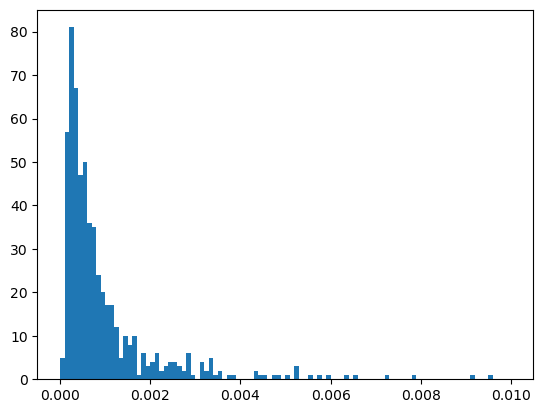

In [510]:
plt.hist(insilico_heatmap_inner.values[np.triu_indices(insilico_heatmap_inner.shape[0], k=0)].flatten(), bins=100, range=(0,0.01))
plt.show()


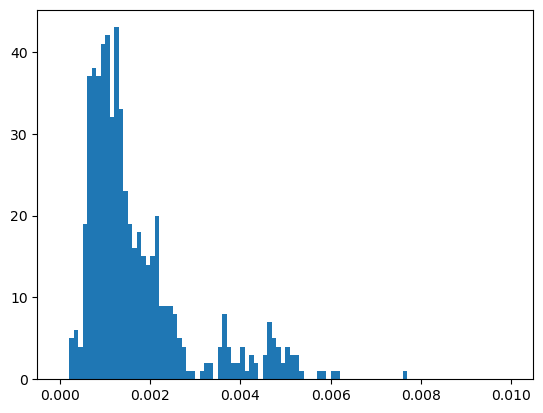

In [511]:
plt.hist(heatmap_denominator.values[np.triu_indices(heatmap_denominator.shape[0], k=0)].flatten(), bins=100, range=(0, 0.01))
plt.show()


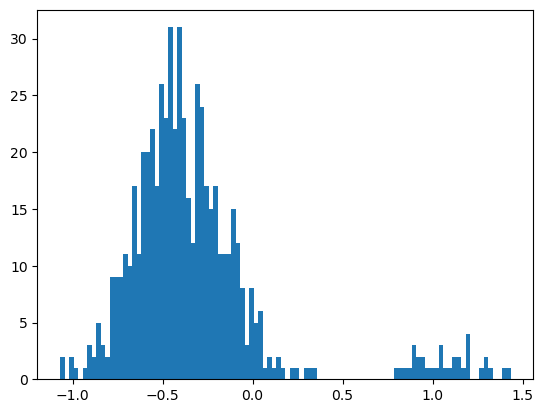

In [512]:
insilico_heatmap_result_final = np.log10(insilico_heatmap_inner / heatmap_denominator)
plt.hist(insilico_heatmap_result_final.values[np.triu_indices(insilico_heatmap_result_final.shape[0], k=0)].flatten(), bins=100)
plt.show()

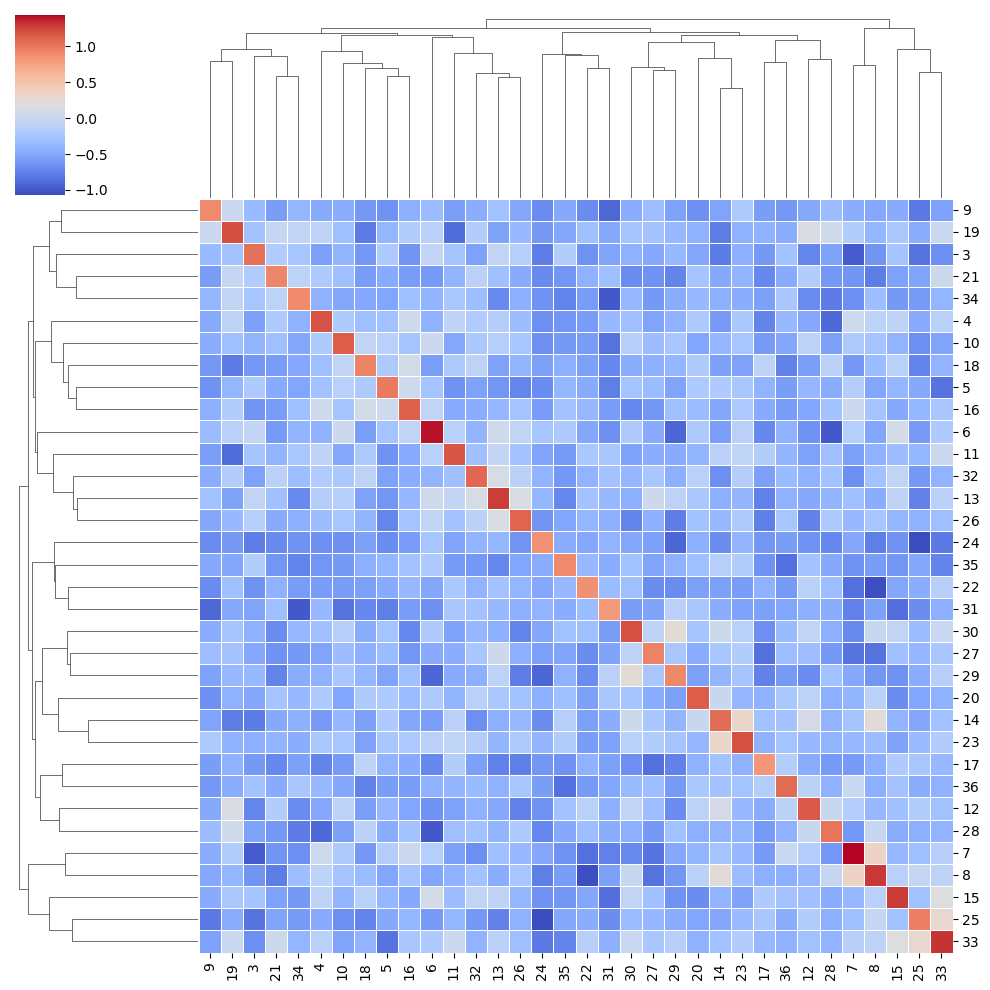

In [513]:
# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(insilico_heatmap_result_final, method='average')

# Define the order of columns based on clustering
order = hierarchy.leaves_list(linkage_matrix)

# Reorder the DataFrame columns based on the clustering order
df_reordered_observed = insilico_heatmap_result_final.iloc[order, order]

# Create a heatmap with a tree hierarchy
clustermap_observed = sns.clustermap(df_reordered_observed, row_cluster=True, col_cluster=True, cmap='coolwarm', linewidths=0.5, figsize=(10, 10))

plt.savefig(f"../../data/{experiment_id}/{experiment_type}/01_observed_interactions_lammps_types.png", dpi=300)
plt.show()

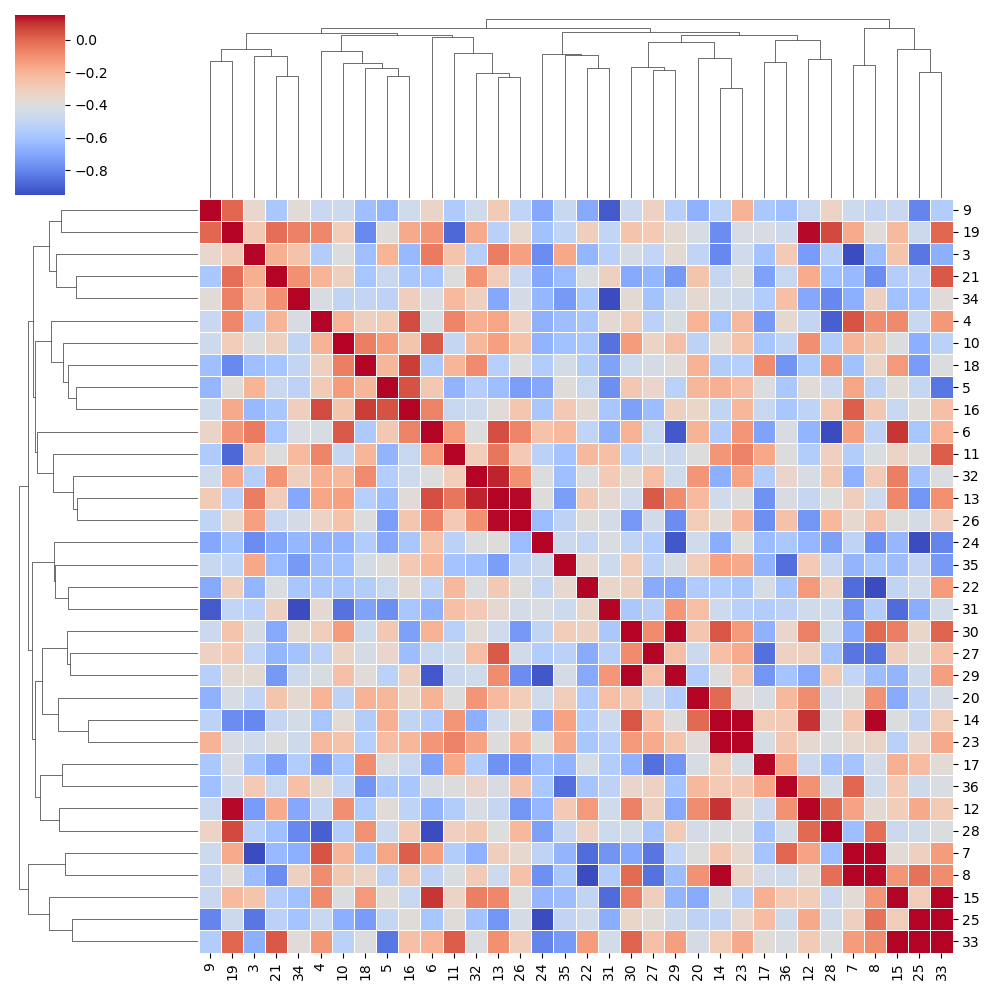

In [517]:
# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(insilico_heatmap_result_final, method='average')

# Define the order of columns based on clustering
order = hierarchy.leaves_list(linkage_matrix)

# Reorder the DataFrame columns based on the clustering order
df_reordered_observed = insilico_heatmap_result_final.iloc[order, order]

# Create a heatmap with a tree hierarchy
clustermap_observed = sns.clustermap(df_reordered_observed, row_cluster=True, col_cluster=True, cmap='coolwarm', linewidths=0.5, figsize=(10, 10), vmax=0.15, vmin=-0.95)

plt.savefig(f"../../data/{experiment_id}/{experiment_type}/01_observed_interactions_vmax_lammps_types.png", dpi=300)
plt.show()

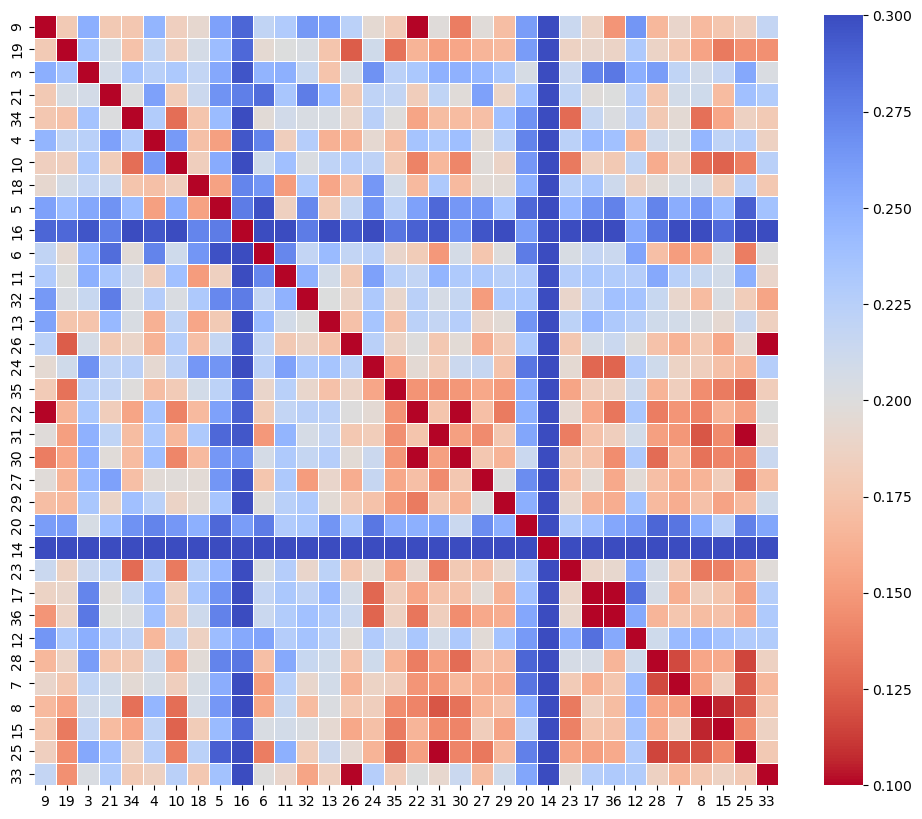

In [518]:
final_labels = clustermap_observed.ax_heatmap.yaxis.get_majorticklabels()
final_labels = [int(x.get_text()) for x in final_labels]

df_reordered_expected = genome_distance_matrix_renamed.reindex(columns=final_labels, index=final_labels)

# df_reordered_expected = 1 / df_reordered_expected

# Create a heatmap with a tree hierarchy

fig, ax = plt.subplots(figsize=(12,10)) 
# sns.heatmap(df_reordered_expected, cmap='coolwarm', linewidths=0.5, ax=ax, vmax=10, vmin=1.8)
clustermap_expected = sns.heatmap(df_reordered_expected, cmap='coolwarm_r', linewidths=0.5, ax=ax, vmax=0.3, vmin=0.1)

plt.savefig(f"../../data/{experiment_id}/{experiment_type}/antton_lammps_type_reordered.png", dpi=300)
plt.show()

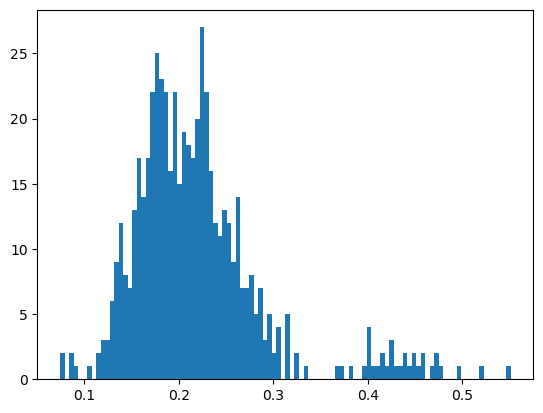

In [519]:

plt.hist(df_reordered_expected.values[np.triu_indices(df_reordered_expected.shape[0], k=1)].flatten(), bins=100)
plt.show()

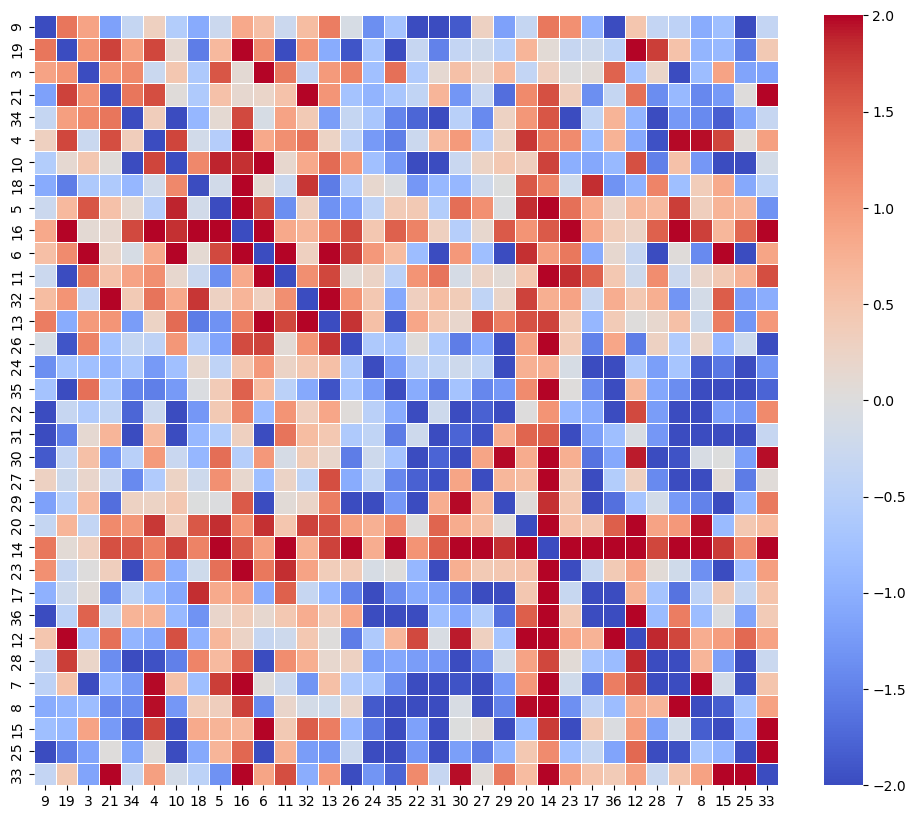

In [520]:
import numpy as np

df_reordered_expected_inverted = 1 / df_reordered_expected
diag_indices_new = np.diag_indices(df_reordered_expected_inverted.shape[0])
df_reordered_expected_inverted.values[diag_indices_new] = 1000000


# Extract the upper triangle of the matrix
upper_triangle_observed = df_reordered_observed.where(np.triu(np.ones(df_reordered_observed.shape), k=1).astype(bool)).values.flatten()
upper_triangle_expected = df_reordered_expected_inverted.where(np.triu(np.ones(df_reordered_expected_inverted.shape), k=1).astype(bool)).values.flatten()
upper_triangle_observed = upper_triangle_observed[~np.isnan(upper_triangle_observed)]
upper_triangle_expected = upper_triangle_expected[~np.isnan(upper_triangle_expected)]

# Calculate the mean and standard deviation of the upper triangle
mean_observed = upper_triangle_observed.mean()
std_observed = upper_triangle_observed.std()

mean_expected = upper_triangle_expected.mean()
std_expected = upper_triangle_expected.std()

# Subtract the mean and divide by the standard deviation for all elements in the matrix
df_reordered_observed_normalized = (df_reordered_observed - mean_observed) / std_observed
df_reordered_expected_normalized = (df_reordered_expected_inverted - mean_expected) / std_expected


fig, ax = plt.subplots(figsize=(12,10)) 
# sns.heatmap(df_reordered_expected, cmap='coolwarm', linewidths=0.5, ax=ax, vmax=10, vmin=1.8)
clustermap_diff = sns.heatmap(df_reordered_observed_normalized - df_reordered_expected_normalized, cmap='coolwarm', linewidths=0.5, ax=ax, vmin=-2, vmax=2)

plt.savefig(f"../../data/{experiment_id}/{experiment_type}/01_diff_obs_exp.png", dpi=300)
plt.show()

<BarContainer object of 34 artists>

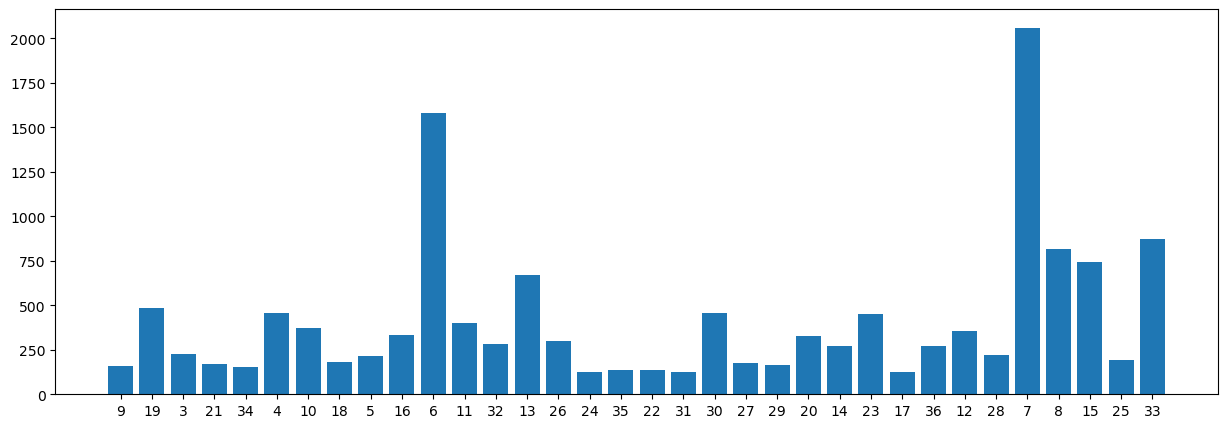

In [521]:
fig, ax = plt.subplots(figsize=(15,5))
plt.bar([str(x) for x in list(num_bac_genomes.loc[df_reordered_observed_normalized.index].index)], list(num_bac_genomes.loc[df_reordered_observed_normalized.index]['count']))

In [522]:
# check if mean observed signal for each type correlates with the number of bacteria of each type

from scipy.stats import pearsonr, spearmanr, kendalltau

df_reordered_observed_corr = df_reordered_observed.copy()

print("Correlation for all types:")
correlation, pvalue = pearsonr(df_reordered_observed_corr.mean(), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(df_reordered_observed_corr.mean(), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(df_reordered_observed_corr.mean(), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))

print("\nCorrelation for diagonal only")
correlation, pvalue = pearsonr(np.diag(df_reordered_observed_corr), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(np.diag(df_reordered_observed_corr), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(np.diag(df_reordered_observed_corr), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))

print("\nCorrelation for non-diagonal only")
np.fill_diagonal(df_reordered_observed_corr.values, np.nan)
correlation, pvalue = pearsonr(df_reordered_observed_corr.mean(), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(df_reordered_observed_corr.mean(), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(df_reordered_observed_corr.mean(), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))


Correlation for all types:
Pearson correlation: 0.45323, 7.10507E-03
Spearman correlation: 0.87683, 1.05189E-11
Kendall correlation: 0.72322, 1.91073E-09

Correlation for diagonal only
Pearson correlation: 0.83055, 1.22183E-09
Spearman correlation: 0.99557, 1.96658E-34
Kendall correlation: 0.96964, 8.18240E-16

Correlation for non-diagonal only
Pearson correlation: 0.42220, 1.28724E-02
Spearman correlation: 0.85666, 1.02358E-10
Kendall correlation: 0.69107, 9.56199E-09


In [523]:
# check if mean observed signal for each type correlates with the number of bacteria of each type

from scipy.stats import pearsonr, spearmanr, kendalltau

df_reordered_observed_corr_diff = (df_reordered_observed_normalized - df_reordered_expected_normalized).copy()

print("Correlation for all types:")
correlation, pvalue = pearsonr(df_reordered_observed_corr_diff.mean(), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(df_reordered_observed_corr_diff.mean(), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(df_reordered_observed_corr_diff.mean(), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))

print("\nCorrelation for diagonal only")
correlation, pvalue = pearsonr(np.diag(df_reordered_observed_corr_diff), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(np.diag(df_reordered_observed_corr_diff), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(np.diag(df_reordered_observed_corr_diff), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))

print("\nCorrelation for non-diagonal only")
np.fill_diagonal(df_reordered_observed_corr_diff.values, np.nan)
correlation, pvalue = pearsonr(df_reordered_observed_corr_diff.mean(), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(df_reordered_observed_corr_diff.mean(), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(df_reordered_observed_corr_diff.mean(), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))


Correlation for all types:
Pearson correlation: 0.14938, 3.99125E-01
Spearman correlation: 0.58450, 2.83510E-04
Kendall correlation: 0.39821, 9.44432E-04

Correlation for diagonal only
Pearson correlation: 0.83055, 1.22183E-09
Spearman correlation: 0.99557, 1.96658E-34
Kendall correlation: 0.96964, 8.18240E-16

Correlation for non-diagonal only
Pearson correlation: 0.12464, 4.82484E-01
Spearman correlation: 0.54951, 7.62448E-04
Kendall correlation: 0.36964, 2.14536E-03


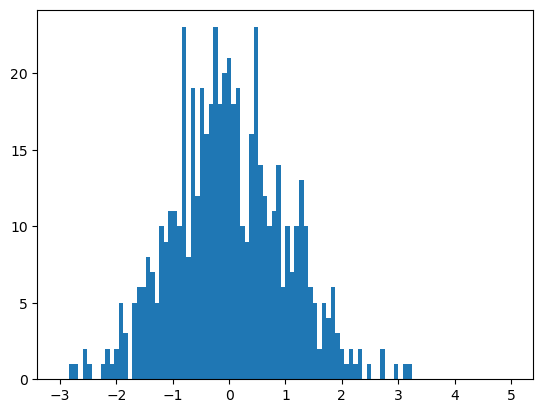

In [524]:

plt.hist(((upper_triangle_observed - mean_observed) / std_observed).flatten(), bins=100, range=(-3,5))
plt.show()

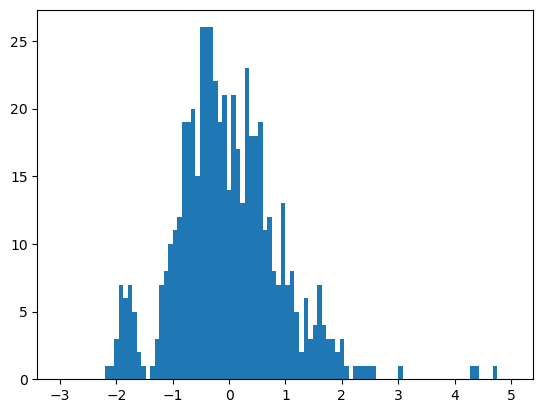

In [525]:
plt.hist(((upper_triangle_expected - mean_expected) / std_expected).flatten(), bins=100, range=(-3,5))
plt.show()

In [526]:
# check correlation between ovserved and expected (not inverted and not normalized)

from scipy.stats import pearsonr, spearmanr, kendalltau

# Flatten the upper triangular part of the matrices
upper_tri_expected = df_reordered_expected.values[np.triu_indices(df_reordered_expected.shape[0], k=1)]
upper_tri_observed = df_reordered_observed.values[np.triu_indices(df_reordered_observed.shape[0], k=1)]


correlation, pvalue = pearsonr(upper_tri_expected, upper_tri_observed)
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(upper_tri_expected, upper_tri_observed)
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(upper_tri_expected, upper_tri_observed)
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))

# Correlation is negative because we use original expected matrix from Antton,
# where lower coefficients mean higher similarity

Pearson correlation: 0.08689, 3.96652E-02
Spearman correlation: 0.08282, 4.99250E-02
Kendall correlation: 0.05365, 5.73931E-02


In [527]:
# check correlation between ovserved and expected (inverted and normalized)

from scipy.stats import pearsonr, spearmanr, kendalltau

# Flatten the upper triangular part of the matrices
upper_tri_expected = df_reordered_expected_normalized.values[np.triu_indices(df_reordered_expected_normalized.shape[0], k=1)]
upper_tri_observed = df_reordered_observed_normalized.values[np.triu_indices(df_reordered_observed_normalized.shape[0], k=1)]


correlation, pvalue = pearsonr(upper_tri_expected, upper_tri_observed)
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(upper_tri_expected, upper_tri_observed)
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(upper_tri_expected, upper_tri_observed)
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))

# Correlation is positive because we use inverted expected matrix from Antton

Pearson correlation: -0.07195, 8.86577E-02
Spearman correlation: -0.08282, 4.99250E-02
Kendall correlation: -0.05365, 5.73931E-02


In [529]:
experiment_type

'both_reshuffled'

In [391]:
if "bacteria" in experiment_type:
	header = ["Step", "Temp", "PotEng", "KinEng", "TotEng", "Press", "c_Tbacteria", "c_KEbacteria", "c_PEbacteria",  "CPU"]
elif "both" in experiment_type:
	header = ["Step", "Temp", "PotEng", "KinEng", "TotEng", "Press", "c_Tbacteria", "c_Tvilli", "c_KEbacteria", "c_KEvilli", "c_PEbacteria", "c_PEvilli",  "CPU"]
pattern = re.compile(r'^\s+\d+')

In [392]:
data_file = f"../../data/{experiment_id}/{experiment_type}/log.lammps"
with open(data_file, 'r') as f:
    lammps_logs = f.readlines()

In [393]:
lammps_logs_selected = [x for x in lammps_logs if pattern.match(x)]

In [394]:
def get_step_rows(x):
    adj_row = [y for y in x.strip("\n").split(' ') if y != '']
    try:
        colnums = 10 if "bacteria" in experiment_type else 13
        if int(adj_row[0]) % 1000 == 0 and '.' in adj_row[2] and '.' not in adj_row[0] and len(adj_row) == colnums:
            return adj_row
    except:
        pass

In [395]:
lammps_logs_selected = [get_step_rows(x) for x in lammps_logs_selected if get_step_rows(x)]

In [396]:
df_lammps_logs_selected = pd.DataFrame(lammps_logs_selected, columns=header)
df_lammps_logs_selected['Step'] = df_lammps_logs_selected['Step'].astype(int)
df_lammps_logs_selected['Temp'] = df_lammps_logs_selected['Temp'].astype(float)
df_lammps_logs_selected['PotEng'] = df_lammps_logs_selected['PotEng'].astype(float)
df_lammps_logs_selected['KinEng'] = df_lammps_logs_selected['KinEng'].astype(float)
df_lammps_logs_selected['TotEng'] = df_lammps_logs_selected['TotEng'].astype(float)
df_lammps_logs_selected['Press'] = df_lammps_logs_selected['Press'].astype(float)
df_lammps_logs_selected['c_Tbacteria'] = df_lammps_logs_selected['c_Tbacteria'].astype(float)
if "both" in experiment_type:
	df_lammps_logs_selected['c_Tvilli'] = df_lammps_logs_selected['c_Tvilli'].astype(float)
df_lammps_logs_selected['c_KEbacteria'] = df_lammps_logs_selected['c_KEbacteria'].astype(float)
if "both" in experiment_type:
	df_lammps_logs_selected['c_KEvilli'] = df_lammps_logs_selected['c_KEvilli'].astype(float)
df_lammps_logs_selected['c_PEbacteria'] = df_lammps_logs_selected['c_PEbacteria'].astype(float)
if "both" in experiment_type:
	df_lammps_logs_selected['c_PEvilli'] = df_lammps_logs_selected['c_PEvilli'].astype(float)
df_lammps_logs_selected['CPU'] = df_lammps_logs_selected['CPU'].astype(float)

df_lammps_logs_selected.index = list(df_lammps_logs_selected['Step'])

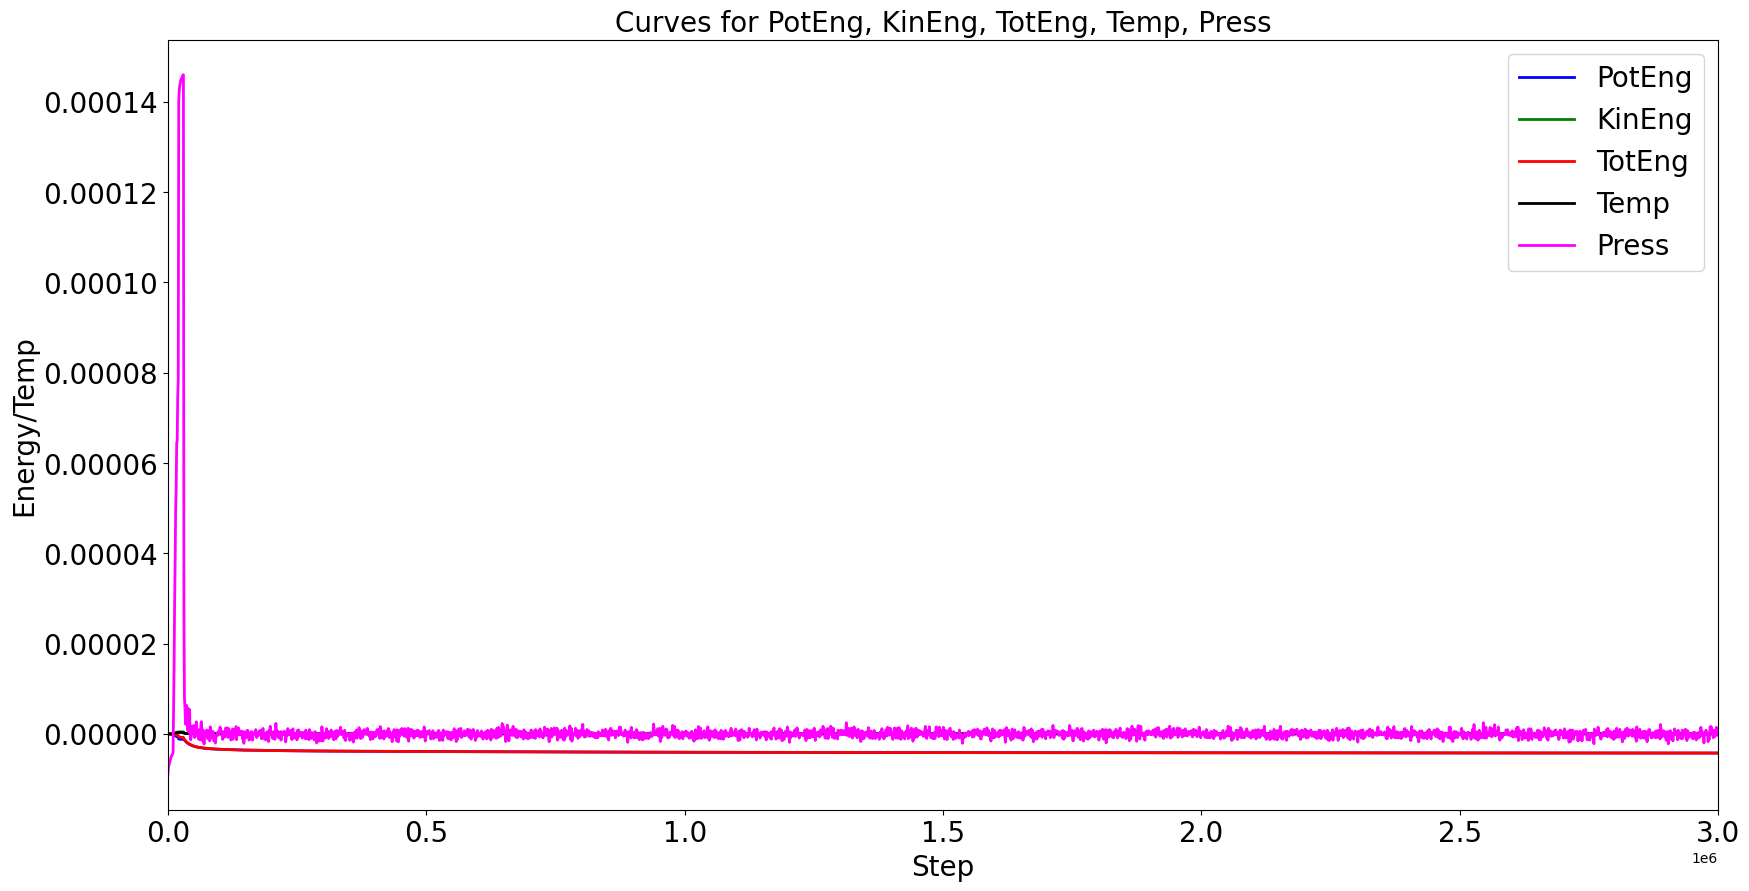

In [397]:
plt.figure(figsize=(20, 10))
# Plot curves for the specified columns
plt.plot(df_lammps_logs_selected['PotEng'], label='PotEng', color='blue', linewidth=2)
plt.plot(df_lammps_logs_selected['KinEng'], label='KinEng', color='green', linewidth=2)
plt.plot(df_lammps_logs_selected['TotEng'], label='TotEng', color='red', linewidth=2)
plt.plot(df_lammps_logs_selected['Temp'], label='Temp', color='black', linewidth=2)
plt.plot(df_lammps_logs_selected['Press'], label='Press', color='magenta', linewidth=2)

# Add labels and legend
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Step', fontsize=20)
plt.ylabel('Energy/Temp', fontsize=20)
plt.title('Curves for PotEng, KinEng, TotEng, Temp, Press', fontsize=20)
# plt.ylim((-3e-6, 1e-6))
#plt.ylim((-0.1, 0.1))
plt.xlim((-0.2, 0.03 * 10e7))
plt.legend(fontsize=20)
plt.savefig(f"../../data/{experiment_id}/{experiment_type}/tot_measurements.png", dpi=300)
# Show the plot
plt.show()

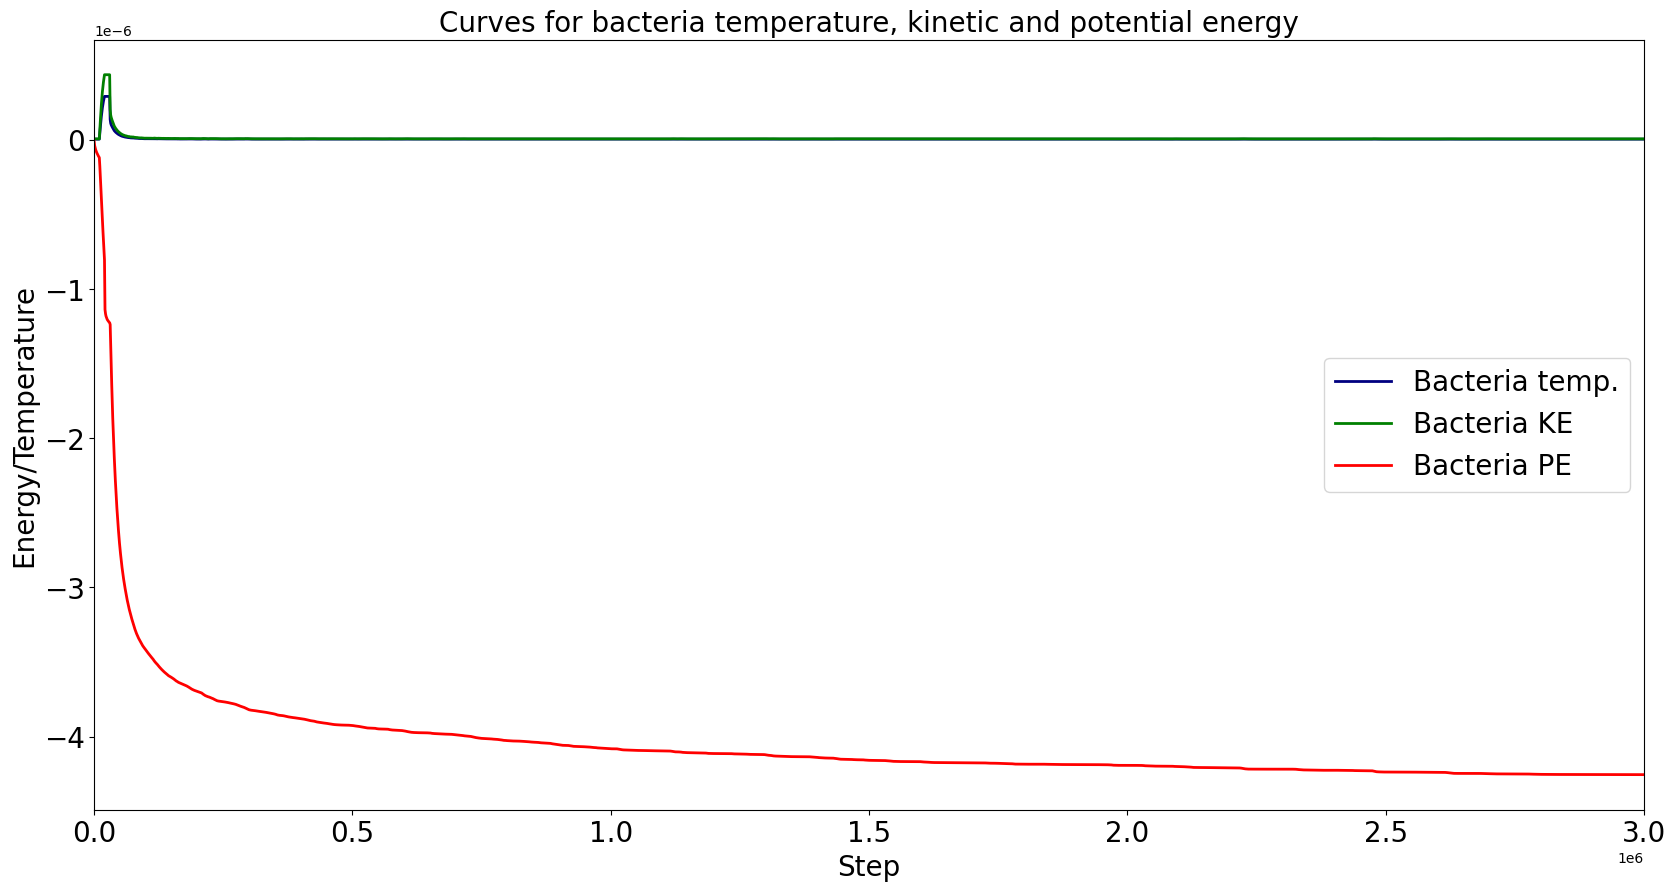

In [398]:
plt.figure(figsize=(20, 10))
# Plot curves for the specified columns
plt.plot(df_lammps_logs_selected['c_Tbacteria'], label='Bacteria temp.', color='navy', linewidth=2)
#plt.plot(df_lammps_logs_selected['c_Tvilli'], label='c_Tvilli', color='cyan')
plt.plot(df_lammps_logs_selected['c_KEbacteria'], label='Bacteria KE', color='green', linewidth=2)
#plt.plot(df_lammps_logs_selected['c_KEvilli'], label='c_KEvilli', color='lime')
plt.plot(df_lammps_logs_selected['c_PEbacteria'], label='Bacteria PE', color='red', linewidth=2)
#plt.plot(df_lammps_logs_selected['c_PEvilli'], label='c_PEvilli', color='magenta')

# Add labels and legend
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Step', fontsize=20)
plt.ylabel('Energy/Temperature', fontsize=20)
plt.title('Curves for bacteria temperature, kinetic and potential energy', fontsize=20)
# plt.ylim((-3e-4, 3e-5))
plt.xlim((-0.2, 0.03 * 10e7))
plt.legend(fontsize=20)
plt.savefig(f"../../data/{experiment_id}/{experiment_type}/bacteria_measurements.png", dpi=300)
# Show the plot
plt.show()

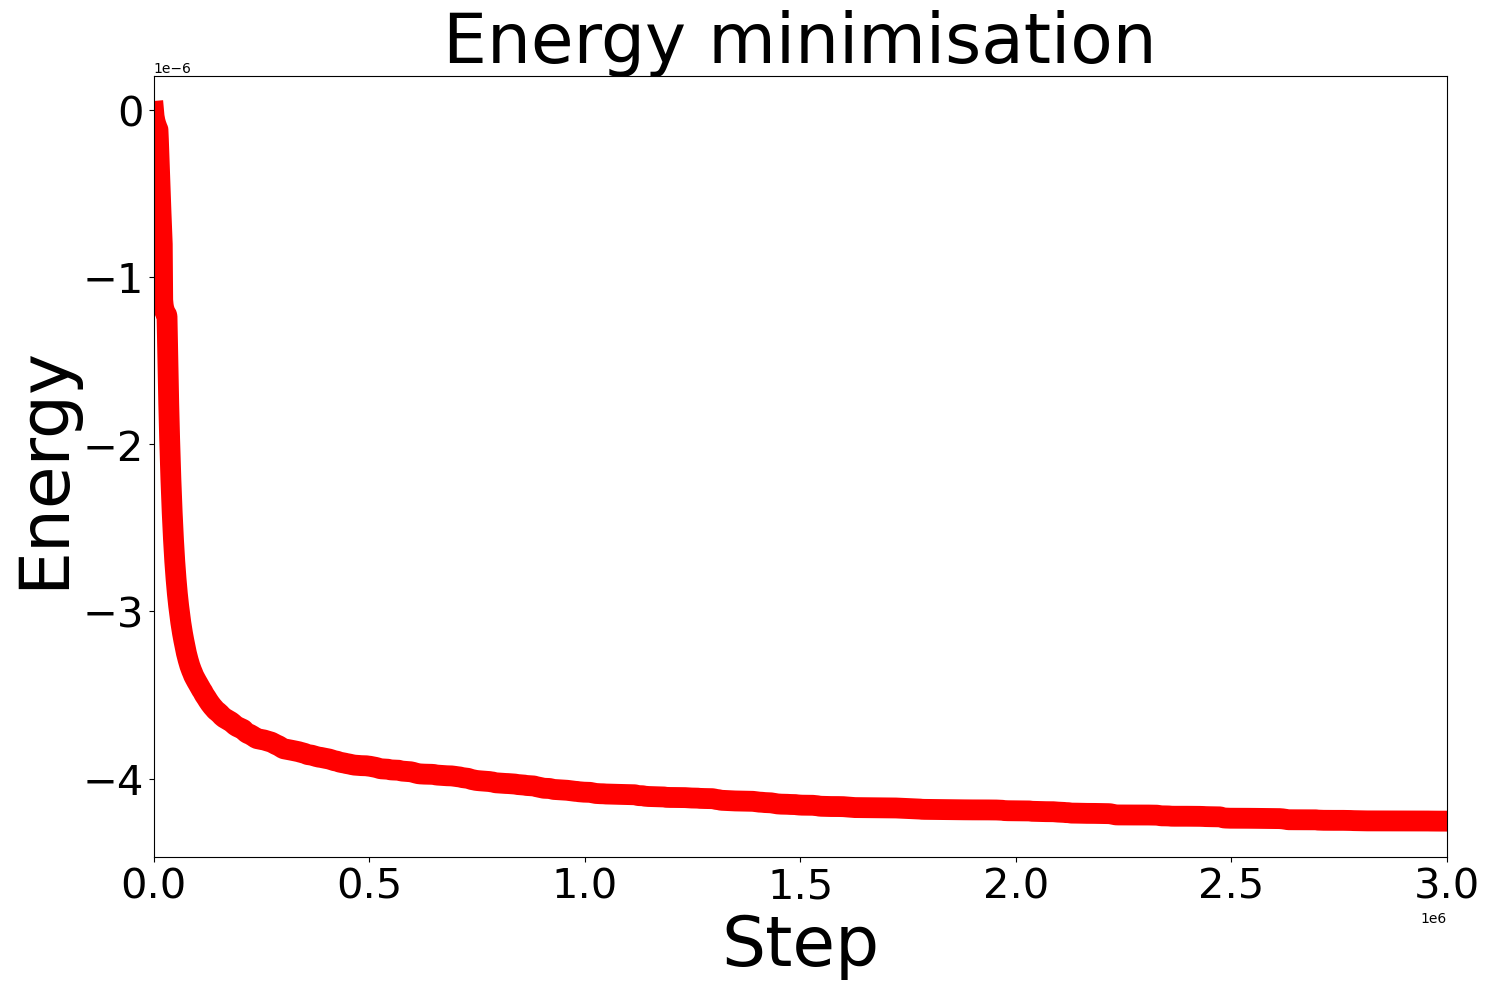

In [352]:
plt.figure(figsize=(15, 10))
# Plot curves for the specified columns
#plt.plot(df_lammps_logs_selected['c_Tbacteria'], label='Bacteria temp.', color='navy', linewidth=2)
#plt.plot(df_lammps_logs_selected['c_Tvilli'], label='c_Tvilli', color='cyan')
#plt.plot(df_lammps_logs_selected['c_KEbacteria'], label='Bacteria KE', color='green', linewidth=2)
#plt.plot(df_lammps_logs_selected['c_KEvilli'], label='c_KEvilli', color='lime')
plt.plot(df_lammps_logs_selected['c_PEbacteria'], label='Bacteria PE', color='red', linewidth=15)
#plt.plot(df_lammps_logs_selected['c_PEvilli'], label='c_PEvilli', color='magenta')

# Add labels and legend
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xlabel('Step', fontsize=70)
plt.ylabel('Energy', fontsize=70)
plt.title('Energy minimisation', fontsize=70)
# plt.ylim((-3e-4, 3e-5))
plt.xlim((-0.2, 0.03 * 10e7))
#plt.legend(fontsize=40)
plt.tight_layout()
plt.savefig(f"../../data/{experiment_id}/{experiment_type}/curve.png", dpi=300)
# Show the plot
plt.show()

In [341]:
if "both" in experiment_type:
	plt.figure(figsize=(20, 10))
	# Plot curves for the specified columns
	#plt.plot(df_lammps_logs_selected['c_Tbacteria'], label='c_Tbacteria', color='navy', linewidth=2)
	plt.plot(df_lammps_logs_selected['c_Tvilli'], label='Villi temp.', color='blue', linewidth=2)
	#plt.plot(df_lammps_logs_selected['c_KEbacteria'], label='c_KEbacteria', color='green', linewidth=2)
	plt.plot(df_lammps_logs_selected['c_KEvilli'], label='Villi KE', color='lime', linewidth=2)
	#plt.plot(df_lammps_logs_selected['c_PEbacteria'], label='c_PEbacteria', color='red', linewidth=2)
	plt.plot(df_lammps_logs_selected['c_PEvilli'], label='Villi PE', color='magenta', linewidth=2)

	# Add labels and legend
	plt.xticks(fontsize=20)
	plt.yticks(fontsize=20)
	plt.xlabel('Step', fontsize=20)
	plt.ylabel('Energy/Temperature', fontsize=20)
	plt.title('Curves for villi temperature, kinetic and potential energy', fontsize=20)
	#plt.ylim((-3e-6, 1e-6))
	plt.xlim((-0.2, 0.04 * 10e6))
	plt.legend(fontsize=20)
	plt.savefig(f"../../data/{experiment_id}/{experiment_type}/villi_measurements.png", dpi=300)
	# Show the plot
	plt.show()

In [330]:
experiment_type

'bacteria_gt'